## notebook setup and configuration

In [15]:
# import numpy, sympy, configure printing and plotting
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
# notebook config
sns.set()                                   # nice plotting defaults
sym.init_printing(use_latex='mathjax')      # render latex for output
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # vectorized plots instead of png

# Solving the 1D Heat Equation symbolically with `SymPy`

We are interested in solving the system

$$-\frac{d^2 u}{dx^2} + \mu u = 0$$

on the domain $\Omega = (0,L)$ where $L=1$ subject to BCs

$$u(0) = 1,\, \frac{du}{dx}\bigg|_L= 0$$

In [17]:
# globals for whole notebook: symbol x, domain Omega
x = sym.Symbol('x')
L = 1
Omega = (0, L)

In [18]:
# convenience functions for derivation and integration
def ddx(f):
    """ derivative of sympy expr f w/r/t x """
    return sym.diff(f, x)

## finding the exact solution

This type of ODE has a commonly known general solution, $c_{1} e^{\sqrt{\mu} x} + c_{2} e^{- \sqrt{\mu} x}$. Just in case I remembered it incorrectly or made a typo, let's have `SymPy` check that it does indeed satisfy the ODE above; the `assert` statement will raise an error if the proceeding expression does not evaluate to `True`.

In [19]:
c1, c2, mu = sym.symbols('c1 c2 mu')

# general solution
gen = c1*sym.exp(sym.sqrt(mu)*x) + c2 * sym.exp(-sym.sqrt(mu)*x)

# check that it satisfies the ODE
assert sym.simplify(-ddx(ddx(gen)) + mu*gen) == 0
gen

    √μ⋅x       -√μ⋅x
c₁⋅ℯ     + c₂⋅ℯ     

We can apply the boundary conditions algebraically to solve for $c_1,\, c_2$

In [20]:
# solve algebraic system for c1, c2 by applying boundary conditions
system = list()
system.append(gen.subs(x,0) - 1)       # solution @ x=0 is 1
system.append(ddx(gen).subs(x, L) - 0) # derivative @ x=L is 0

from sympy.solvers.solveset import linsolve
C_solution = linsolve(system, (c1, c2))
C1, C2 = next(iter(C_solution))
C1, C2

⎛              2⋅√μ  ⎞
⎜    1        ℯ      ⎟
⎜─────────, ─────────⎟
⎜ 2⋅√μ       2⋅√μ    ⎟
⎝ℯ     + 1  ℯ     + 1⎠

Now that we have solved the linear system for $c_1,\, c_2$, we can get the exact solution by substituting for the unknown coefficients.

In [21]:
# evaluate the exact solution using the solved-for coefficients
exact_solution = sym.simplify(gen.subs([(c1, C1), (c2, C2)]))
exact_solution

⎛ 2⋅√μ    2⋅√μ⋅x⎞  -√μ⋅x
⎝ℯ     + ℯ      ⎠⋅ℯ     
────────────────────────
        2⋅√μ            
       ℯ     + 1        

Just to be sure, we let `SymPy` check that our final result satisfies the original ODE as well as each of the boundary conditions. We use the `assert` statement, which will raise an `AssertError` if the following statement does not evaluate to `True`.

In [22]:
# check that exact solution satisfies the ODE, BCs
assert -ddx(ddx(exact_solution)) + mu * exact_solution == 0
assert ddx(exact_solution).subs(x, L) == 0
assert exact_solution.subs(x, 0) == 1

If we have a corresponding `*.tex` document to which we want to add the exact solution, we don't want to transcribe the solution by hand-- this is time-consuming and error-prone; we can instead ask `SymPy` for the latex output directly.

In [23]:
# render the latex of the solution to paste into *.tex file
ex_sol_latex = sym.latex(exact_solution)
print(ex_sol_latex)

\frac{e^{- \sqrt{\mu} x}}{e^{2 \sqrt{\mu}} + 1} \left(e^{2 \sqrt{\mu}} + e^{2 \sqrt{\mu} x}\right)


## vectorized substitution with `lambdify`

One of the downsides of symbolic manipulation is that substitution is __slow__; evaluating our exact solution numerically over our domain of interest would be expensive if done symbolically. Fortunately, `SymPy` implements a `lambdify` method which allows us to create a vectorized function that can numerically evaluate a symbolic expression quickly at many points by leveraging `NumPy`. Since we are done finding our exact solution, let's build a function which takes as input a vector `x` and $\mu$ `mu` and returns the exact solution.

In [24]:
# build a vectorized function to evaluate our exact solution
u_exact = sym.lambdify((x, mu), exact_solution, "numpy")

Now we've done the symbolic heavy lifting; we now query our exact solution for differing values of $\mu$ like any other `NumPy` function  and move on. As a last step, let's use `u_exact` to plot the exact solution numerically.

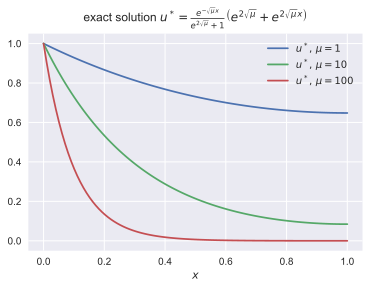

In [25]:
# plot the exact solution over Omega, for differing values of mu
N = 100
mus = [1, 10, 100]
xx = np.linspace(Omega[0], Omega[1], N)

def plot_exact(xx, mus):
    """plots exact solution 
    @param xx  np vector of spatial points at which to plot
    @param mus  list of values for mu
    """
    for mu in mus:
        plt.plot(xx, u_exact(xx,mu),label=r'$u^*,\, \mu = {}$'.format(mu))
    plt.title(r'exact solution $u^* = {}$'.format(ex_sol_latex), y=1.03)
    plt.xlabel(r'$x$')
    plt.legend()
    plt.show()

plot_exact(xx, mus)

## bonus: symbolic galerkin approximation

Suppose we were unable to find an exact solution; we might want to compute the galerkin approximation symbolically as part of the investigation, since this is a 1D problem. 

We can express the weak form of the problem as searching for $u \in \tilde{X}$ such that $a(u,v) = f(v)\,\, \forall v\in \tilde{X}$, where 

$$    a\left( w,\,v \right) = \int_{0}^{L} \left( \frac{dw}{dx} \frac{dv}{dx} + \mu_0 w v \right)\,dx \label{1:wfa}
$$

and $f(v)=0$ since we have no interior forcing ( $f_\Omega = 0$ ).

In [ ]:
def integrate_domain(f):
    """ integrate sympy expression f over domain \Omega w/r/t x """
    return sym.integrate(f, (x, Omega[0], Omega[1]))

In [ ]:
def a(w, v, mu0):
    """ symbolically evaluate the bilinear form a(w,v) """
    return integrate_domain( ddx(w)*ddx(v) + mu0*w*v )

# functional f(v)
def f(v): return 0

If we are searching for the solution $u$ tested for __all__ $v\in\tilde{X}$ such that $a(u_G, v) = f(v)$, then we test $u$ against each basis function $\psi_i$, forming a linear system.

We take $u_G = \alpha_i \psi_i$, and since we have an inhomogenous Dirichlet boundary condition, we can write the problem as:

$$a\left(u_G^0, v\right) = f(v) - a\left(w^E_n, v\right)$$

For choice of lifting function $w^E_n$.

We can write two functions which leverage `SymPy` and the weak forms above to solve the linear system for the galerkin coefficients.

In [ ]:
def Fi(wEn, psi, mu0):
    """ return Load vector entry """
    return f(psi) - a(wEn, psi, mu0)

def galerkin_approx(basis, wEn, mu0):
    """ computes the galerkin approximation to the Q1 problem
    @param basis  list of sympy expressions denoting the approx basis
    @param wEn  sympy expression of the lifting function
    """
    # assemble/solve linear system for galerkin coefficients
    n = len(basis)
    A, F = sym.zeros(n, n), sym.zeros(n, 1)
    for i in range(n):
        for j in range(n):
            psi_i, psi_j = basis[i], basis[j]
            A[i, j] = a(psi_j, psi_i, mu0)
        F[i,0] = Fi(wEn, psi_i, mu0)
    alpha = A.LUsolve(F)

    # build galerkin solution
    uG = 0
    for i, alpha_i in enumerate(alpha):
        uG += alpha_i * basis[i]
    uG += wEn
    return uG

#### I. galerkin approximation $u_G^I$

The first galerkin approximation $u_G^{I}$ we consider $\tilde{X} = \text{span}\left\{ x\right\},\, \psi_1 = x$ with the lifting function $w^E_n = 1$. We can create a dictionary of our exact galerkin solutions,  with the value as the symbolic galerkin expression, indexed by the value of $\mu$.

In [ ]:
uG_I = dict()
X_G, wEn = [x], 1
mu0s = [sym.Rational(1,10), 1, 10]
for mu0 in mu0s:
    uG_I[mu0] = galerkin_approx(X_G, wEn, mu0)
uG_I

Let's see how the galerkin solutions compare to the exact solution. 

Note that we turn each `SymPy` expression into a lambdified expression, just like we did for the exact solution.

In [ ]:
def plot_galerkin_and_exact(uG, mu0s):
    """ plot a set of galerkin solutions vs exact """
    colors=sns.color_palette()
    for idx, mu0 in enumerate(mu0s):
        _ug = sym.lambdify(x, uG[mu0], "numpy")
        plt.plot(xx, _ug(xx), color=colors[idx],
                 label=r'$u_G,\, \mu = {}$'.format(mu0))
        plt.plot(xx, u_exact(xx, float(mu0)), '--')
    plt.legend(loc='lower left')
    plt.title(r'Galerkin solutions $u_G$ and exact solutions $u^*$')
    plt.show()

plot_galerkin_and_exact(uG_I, mu0s)

#### II. galerkin approximation $u_G^{II}$

The second galerkin approximation $u_G^{II}$ we consider $\tilde{X} = \text{span}\left\{ x\right\},\, \psi_1 = x$ with the lifting function $w^E_n = \exp\left(-\sqrt{\mu}x\right)$. We can create a dictionary of our exact galerkin solutions,  with the value as the symbolic galerkin expression, indexed by the value of $\mu$. We can plot these by calling the same function above.

In [ ]:
uG_II = dict()
mu0s = [sym.Rational(1,10), 1, 10]
for mu0 in mu0s:
    X_G, wEn = [x], sym.exp(-sym.sqrt(mu0)*x)
    uG_II[mu0] = galerkin_approx(X_G, wEn, mu0)
uG_II

In [ ]:
plot_galerkin_and_exact(uG_II, mu0s)

#### III. galerkin approximation $u_G^{III}$

For fun, how would a second order approximation do with a constant lifting function? It's not really any additional work, since our code is general in its input w/r/t basis.

The third galerkin approximation $u_G^{III}$ we consider $\tilde{X} = \text{span}\left\{ x,\, x^2\right\},\, \psi_1 = x,\, \psi_2=x^2$ with the lifting function $w^E_n = 1$. We can create a dictionary of our exact galerkin solutions,  with the value as the symbolic galerkin expression, indexed by the value of $\mu$. We can plot these by calling the same function above.

In [ ]:
uG_III = dict()
X_G, wEn = [x, x**2], 1
mu0s = [sym.Rational(1,10), 1, 10]
for mu0 in mu0s:
    uG_III[mu0] = galerkin_approx(X_G, wEn, mu0)
uG_III

In [ ]:
plot_galerkin_and_exact(uG_III, mu0s)

#### error considerations

It's pretty clear from the output above that $u_G^{II}$ is going to have a much smaller error than $u_G^{I}$ as measured in the energy norm, because we made plots along with the galerkin approximations. 

But suppose we had to choose which galerkin approximation was best without reference to the exact solution. How could we do it?

We seek the approximation which provides the smallest error in the energy norm. Note that $a(w,w) = \int_{0}^{L} \left( \frac{dw}{dx}
    \right)^{2} + \mu_0 w^2 dx$ and $f(v) = 0$ hence 
    
$$\Pi(w) = \frac{1}{2}\int_{\Omega}\left[ \left(
      \frac{dw}{dx} \right)^2 + \mu_0 w^2 \right]\, dx$$

The galerkin approximations $u_G$ have the nice property that $\Pi(u^*) \leq \Pi(u_G)$ for any $u_G$. In other words, that the exact solution $u^*$ is the argument which minimizes the energy functional $\Pi$, and any galerkin solution will have a greater "energy".

We can simply take our galerkin solutions $u_G^{I},\, u_G^{II}$ and evaluate the "energies" $\Pi(u_G)$ symbolically to see which approximation has the smaller "energy."

Consider $\mu_{0} = \frac{1}{10},\, 1,\, 10$ and $n=1$. 

In [ ]:
def Pi(w, mu0):
    """ evaluates the pot. energy functional assoc. w/ the weak form
    @param w  symbolic expression w
    """
    return sym.Rational(1,2)*integrate_domain((ddx(w))**2 +mu0*(w**2))

def energy_norm(w, mu0):
    """ evaluates the energy norm of a function w"""
    return sym.sqrt( a(w, w, mu0) )
                      
def U(w, mu0):
    """evaluates the no-adjective energy functional """
    return a(w, w, mu0)

We can evaluate $\Pi(u_G)$ for each galerkin approximation, $\mu$ pair symbolically. Before printing, we cast the exact symbolic expressions to floating point numbers (we print to 3 significant digits) for ease of visual comparison. 

In [ ]:
mu0s = [sym.Rational(1,10), 1, 10]
print('potential energy:')
print('{:12}{:10}{:10}'.format('mu', 'uG I', 'uG II'))
for mu0 in mu0s:
    _ugI = uG_I[mu0]
    _ugII = uG_II[mu0]
    print('{:<5} {:10.3} {:10.3}'.format(
        mu0, float(Pi(_ugI, mu0)), float(Pi(_ugII, mu0)) ))
 
print('\n')
print('no-adjective energy:')
print('{:12}{:10}{:10}'.format('mu', 'uG I', 'uG II'))
for mu0 in mu0s:
    _ugI = uG_I[mu0]
    _ugII = uG_II[mu0]
    print('{:<5} {:10.3} {:10.3}'.format(
        mu0, float(U(_ugI, mu0)), float(U(_ugII, mu0)) ))

As we expected, galerkin approximation $u_G^{II}$ has a smaller error in the energy norm than does $u_G^{I}$.